# Importing Required Libraries

In [2]:
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import matplotlib.pyplot as plt

# Loading Dataset

In [3]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained('t5-small')

# Preprocessing

In [4]:
# Preprocessing function
def preprocess_data(examples):
    inputs = examples['article']
    targets = examples['highlights']
    
    # Tokenizing inputs
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    
    # Tokenizing targets using `text_target`
    labels = tokenizer(text_target=targets, max_length=150, truncation=True)
    
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Apply preprocessing
tokenized_dataset = dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

# EDA

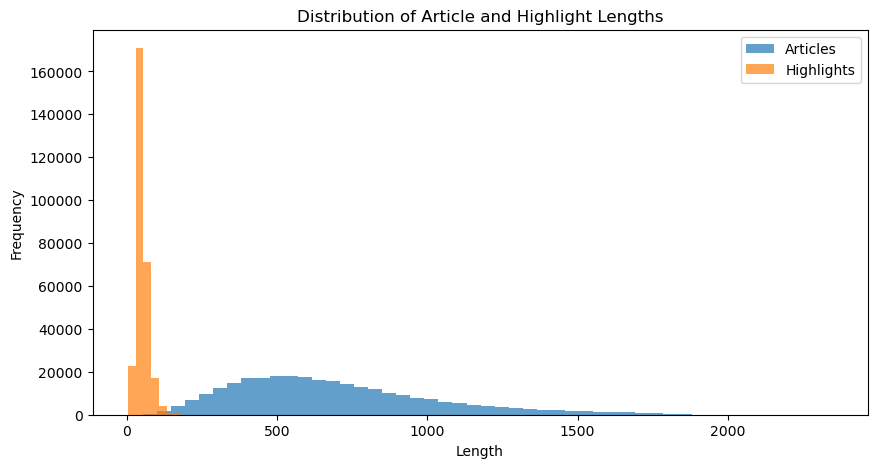

In [5]:
article_lengths = [len(article.split()) for article in dataset['train']['article']]
highlight_lengths = [len(highlight.split()) for highlight in dataset['train']['highlights']]

plt.figure(figsize=(10, 5))
plt.hist(article_lengths, bins=50, alpha=0.7, label='Articles')
plt.hist(highlight_lengths, bins=50, alpha=0.7, label='Highlights')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Article and Highlight Lengths')
plt.show()

# Loading and Training the Model

In [6]:
# Load a pre-trained model
model = AutoModelForSeq2SeqLM.from_pretrained('t5-small')

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    logging_dir='./logs',
)

In [8]:
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Evaluate model before fine-tuning
results_before = trainer.evaluate()

In [14]:
results_before

{'eval_loss': 2.694408416748047,
 'eval_runtime': 23046.6375,
 'eval_samples_per_second': 0.58,
 'eval_steps_per_second': 0.145}